In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizerFast

tokenizer = DPRContextEncoderTokenizerFast.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")
model = DPRContextEncoder.from_pretrained("../temp/dpr/models/ctx_encoder_dpr")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


In [96]:
import pandas as pd

df = pd.read_json("../data/totto2/filtered/train.jsonl", lines=True)

In [97]:
import json

df["table_values"] = df["table"].apply(lambda x: pd.DataFrame(json.loads(x)).values.flatten().tolist())

In [98]:
import itertools


all_values = list(itertools.chain.from_iterable(df["table_values"].tolist()))

In [99]:
import random

sampled_values = random.sample(all_values, 10000)

In [100]:
import re
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

2022-09-25 17:57:36,669 loading file /root/.flair/models/en-ner-conll03-v0.4.pt


In [77]:
labels = []

for value in sampled_values:
    if not re.search('[A-Za-z]', value):
        labels.append(1)
    else:
        sentence = Sentence(str(value))
        tagger.predict(sentence)
        for entity in sentence.get_spans('ner'):
            tag = entity.get_labels("ner")[0].value
            labels.append(2)
            break
        else:
            labels.append(0)

In [78]:
encodings = []

for value in sampled_values:
    inputs = tokenizer(value, return_tensors="pt", padding=True, truncation=True)
    encoding = model(**inputs).pooler_output.detach().cpu().numpy()
    encodings.append(encoding[0])

In [79]:
from sklearn.decomposition import PCA

three_dim = PCA(random_state=0, n_components=2).fit_transform(encodings)[:,:2]

In [88]:
import numpy as np
from sklearn.manifold import TSNE

two_dim = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(np.asarray(encodings))

/opt/conda/envs/read/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/read/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

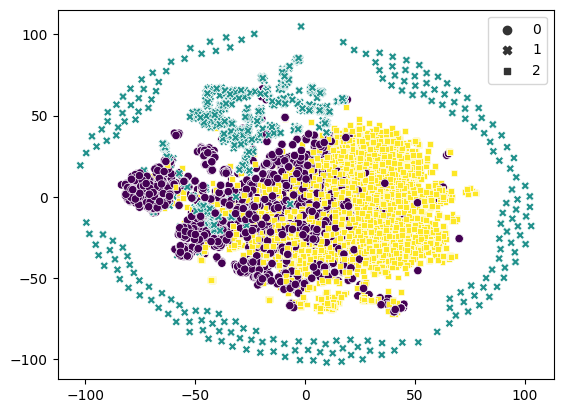

In [93]:
sns.scatterplot(x=two_dim[:, 0], y=two_dim[:, 1], c=labels, style=labels)

<AxesSubplot:>

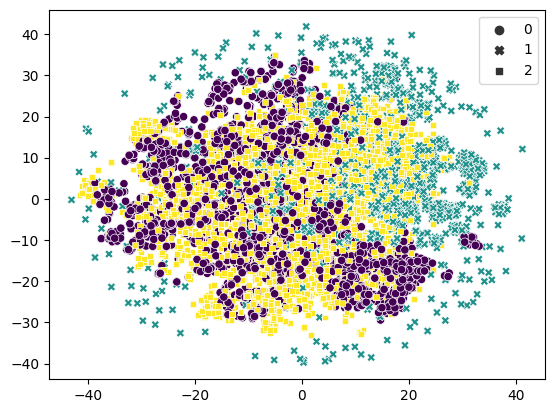

In [83]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
sns.scatterplot(x=two_dim[:, 0], y=two_dim[:, 1], c=labels, style=labels)

In [71]:
two_dim.shape

(100, 2)